In [1]:
import numpy as np
import matplotlib.pyplot as plt
import panel as pn
import datetime as dt
from get_data import get_urls_mod, get_urls_obs, get_data, get_height_vars, calc_model_height

In [2]:
pn.extension()

In [3]:
#selection of site
site_name = pn.widgets.Select(
    name="Site", options=['sodankyla','tiksi','nyalesund'],value='nyalesund', margin=(0, 20, 0, 0)
)

#user selection variable
variable = pn.widgets.Select(
    name="Variables", options=['ta'], margin=(0, 20, 0, 0)
)

#selection of model
model_name = pn.widgets.Select(
    name="model", options=['AROME-Arctic','ifs-ecmwf'],value='ifs-ecmwf', margin=(0, 20, 0, 0)
)

#user selection start and end date only sop 1 as of right now
dates = pn.widgets.DateRangeSlider(
    name='Date Range Slider',
    start=dt.datetime(2018, 2, 1), end=dt.datetime(2018, 3, 31),
    value=(dt.datetime(2018, 2, 1), dt.datetime(2018, 2, 4))
)

#user selection start time for model 
start_time = pn.widgets.Select(
    name="Start time", options=['00','12'], margin=(0, 20, 0, 0)
)

#user selection of which day should be fetched from the model files
#for concat
concat_day = pn.widgets.Select(
    name="Model day selected", options={1:0,2:1,3:2}, margin=(0,20,0,0)
)

top_height = pn.widgets.IntSlider(name='Height', start=100, end=12000, step=1000, value=100)


In [18]:
def contour(data_mod,data_obs,variable,top_height, site_name, model_name):
    print(data_mod,data_obs)
    data_filtered = data_mod[data_mod['height'] < top_height+100].unstack()
    var = data_filtered[variable].values
    heights = data_filtered['height'].values
    time = data_filtered.index.values
    
    time_w_dims = np.full(np.shape(var.T),time).T


    fig0 = plt.figure(figsize=(10,5))
    ax0 = fig0.subplots()
    plot = ax0.contourf(time_w_dims,heights,var)
    plt.ylim(top = top_height)
    fig0.colorbar(plot)
    
    title = "Site: "+site_name+", Model: "+model_name+'\n'+"Variable: "+variable
    ax0.title.set_text(title)
    mpl_pane = pn.pane.Matplotlib(fig0, dpi=144)
    mpl_pane.param.trigger('object')

    return mpl_pane

In [19]:
@pn.depends(site_name,model_name,variable,dates,start_time,concat_day,top_height)
def get_plot(site_name,model_name,variable,dates,start_time,concat_day,top_height):
    #get data
    variables = get_height_vars(model_name)
    variables.append(variable)
    
    urls_mod = get_urls_mod(dates[0],dates[1],start_time,model_name,site_name,variables,concat_day)
    url_obs = get_urls_obs(site_name, "timeSeriesProfile","1")
 
    
    data_mod, err_mod = get_data("concatenated",urls_mod,"model",concat_day)
    data_obs, err_obs = get_data("observation",url_obs,"observation")

    if err_mod is not None:
        #loading.value = False
        pane = pn.pane.Alert("Fetching model: "+err_mod)
        return pane
    elif err_obs is not None:
        #loading.value = False
        return pn.pane.Alert("Fetching observations: "+err_obs)
    
    data_mod = calc_model_height(model_name,data_mod)
    data_mod = data_mod[[variable,"height"]].to_dataframe()
    
    data_obs = data_obs[variable].to_dataframe()
    print(data_obs)
    #=================
    plot = contour(data_mod,data_obs,variable,top_height,site_name,model_name)
    
    return plot

                                          ta
time01              height_tower            
2018-02-01 00:00:00 2.0           264.549988
                    10.0          264.549988
2018-02-01 00:01:00 2.0           264.549988
                    10.0          264.549988
2018-02-01 00:02:00 2.0           264.649994
...                                      ...
2018-03-31 23:57:00 10.0          257.149994
2018-03-31 23:58:00 2.0           255.750000
                    10.0          257.049988
2018-03-31 23:59:00 2.0           255.649994
                    10.0          256.949982

[169920 rows x 1 columns]
                               ta        height
time                level                      
2018-02-01 00:07:30 0      213.09  77306.096612
                    1      227.15  71272.765332
                    2      234.86  68430.856057
                    3      240.93  65702.825463
                    4      245.40  63097.382923
...                           ...           ...
2018

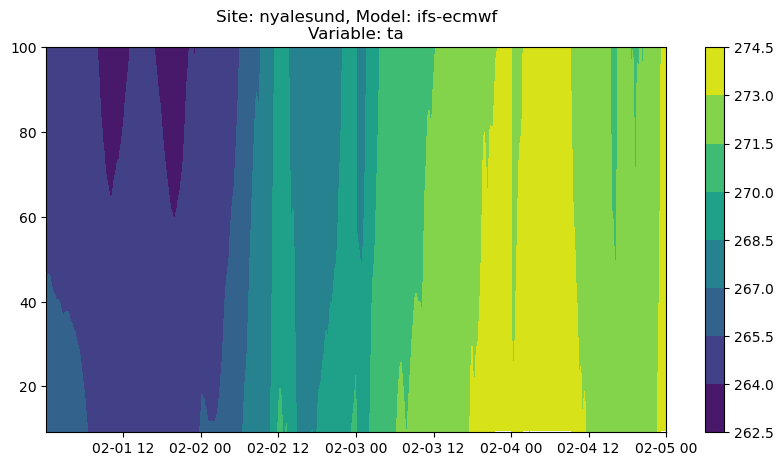

In [20]:
pn.serve(pn.Column("scatter 2 sop 1", get_plot, pn.Row(
    pn.Column(site_name,model_name,variable),
    pn.Column(dates,start_time,concat_day),
    pn.Column(top_height)),width_policy="max"))
          